# Training transformer

## Import package

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional


In [2]:
set_seed(0)

In [3]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        self.data = data
        self.mode = mode
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        # Union - 多态，匹配多种类型
        '''
        train: return -> (input_ids, labels)
        dev: return -> (input_ids, labels)
        test: -> input_ids
        '''
        sequence = self.data[idx] # 拿出指定序号的色彩列
        # 注意这里的transformer训练特点
        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype = torch.long) # 用来输入decoder的是最后一个之前的pixel
            labels = torch.tensor(sequence[1:], dtype = torch.long) # 用来label的是除了第一个之外的label
            # 因为这里输入和输出都是固定长度的，所以不需要什么起始和终止，也不需要tokenizer
            return input_ids, labels
        elif self.mode == "dev":
            # 验证的话，后160像素用来验证
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels
        elif self.mode == "test":
            # test的话就全拿走
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")
    
    
    

## download dataset

In [35]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")
# (index, 400, num_classes)

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])
# colarmap 是序号和颜色的对应表 (colar_classes, 3(rgb))

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 32

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

print(num_classes)

167


In [5]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier
    # 最多输出96张

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

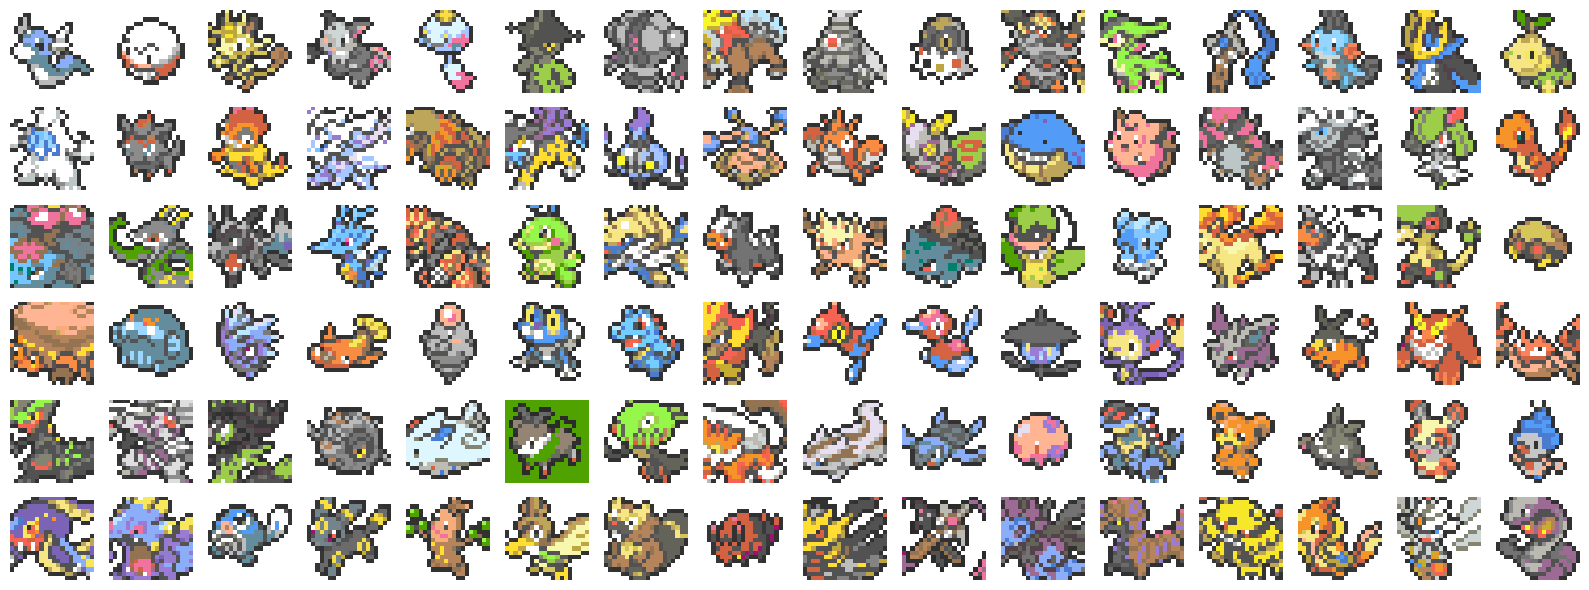

In [6]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

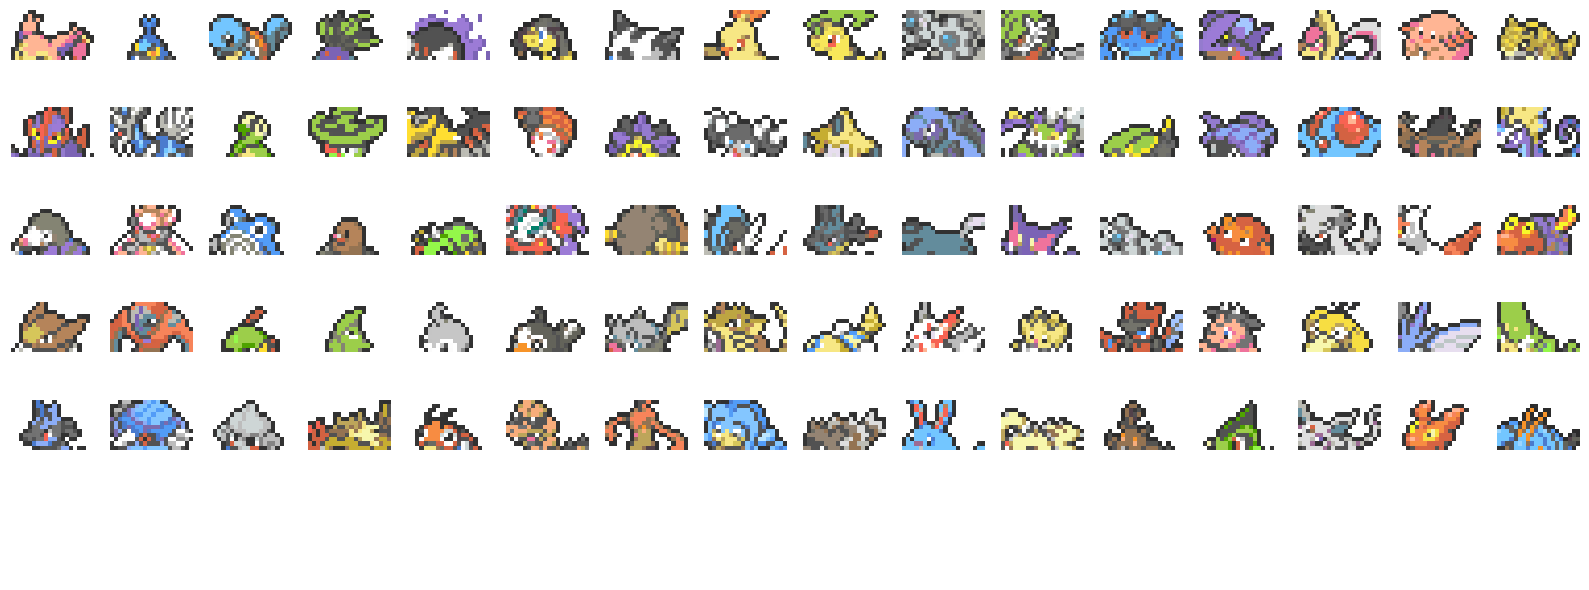

In [7]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

## prepare model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)

In [36]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 400,               # Context size (maximum sequence length)
    "n_embd": 256,              # Embedding size
    # 也就是residual stream的size， dmodel
    "n_head": 4,               # Number of attention heads
    "n_layer": 6,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    # 最大位置数量，超过这个就没有位置编码了
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(gpt2_config)

In [37]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(167, 256)
    (wpe): Embedding(400, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=768, nx=256)
          (c_proj): Conv1D(nf=256, nx=256)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1024, nx=256)
          (c_proj): Conv1D(nf=256, nx=1024)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=167, bias=False)
)
Trainable Parameters: 4,884,224


## Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [53]:
# Training Parameters
epochs = 200                                     # Number of training epochs
learning_rate = 2e-4                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints_gpt2"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

In [54]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [55]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf') # 这样写直接就是最小值啊
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model
        # 需要手动吧torch传到显卡上

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels) # 算交叉熵
        # 再次强调交叉熵是logits (seq_len, classes) 直接和labels (seq_len)做的

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item() # 累加一整个epoch的loss

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader) # 算这个epoch平均loss
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:] # 验证集的label直接就是后160个，那走就行

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss
    
    print("--------------------------------------------------- \n")

Training Epoch 1/200: 100%|██████████| 20/20 [00:01<00:00, 15.99it/s]


Epoch 1/200, Loss: 0.4118


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 1/200, Reconstruction Accuracy: 0.3266
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.4118, Epoch: 1)
--------------------------------------------------- 



Training Epoch 2/200: 100%|██████████| 20/20 [00:01<00:00, 16.40it/s]


Epoch 2/200, Loss: 0.3813


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 2/200, Reconstruction Accuracy: 0.3663
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3813, Epoch: 2)
--------------------------------------------------- 



Training Epoch 3/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 3/200, Loss: 0.3535


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 3/200, Reconstruction Accuracy: 0.3630
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3535, Epoch: 3)
--------------------------------------------------- 



Training Epoch 4/200: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 4/200, Loss: 0.3395


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 4/200, Reconstruction Accuracy: 0.3525
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3395, Epoch: 4)
--------------------------------------------------- 



Training Epoch 5/200: 100%|██████████| 20/20 [00:01<00:00, 16.38it/s]


Epoch 5/200, Loss: 0.3297


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 5/200, Reconstruction Accuracy: 0.3407
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3297, Epoch: 5)
--------------------------------------------------- 



Training Epoch 6/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 6/200, Loss: 0.3230


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 6/200, Reconstruction Accuracy: 0.3689
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3230, Epoch: 6)
--------------------------------------------------- 



Training Epoch 7/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 7/200, Loss: 0.3205


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 7/200, Reconstruction Accuracy: 0.3699
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3205, Epoch: 7)
--------------------------------------------------- 



Training Epoch 8/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 8/200, Loss: 0.3178


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 8/200, Reconstruction Accuracy: 0.3684
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3178, Epoch: 8)
--------------------------------------------------- 



Training Epoch 9/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 9/200, Loss: 0.3146


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 9/200, Reconstruction Accuracy: 0.3600
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3146, Epoch: 9)
--------------------------------------------------- 



Training Epoch 10/200: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 10/200, Loss: 0.3122


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 10/200, Reconstruction Accuracy: 0.3608
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3122, Epoch: 10)
--------------------------------------------------- 



Training Epoch 11/200: 100%|██████████| 20/20 [00:01<00:00, 16.43it/s]


Epoch 11/200, Loss: 0.3106


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 11/200, Reconstruction Accuracy: 0.3396
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3106, Epoch: 11)
--------------------------------------------------- 



Training Epoch 12/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 12/200, Loss: 0.3027


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 12/200, Reconstruction Accuracy: 0.3282
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.3027, Epoch: 12)
--------------------------------------------------- 



Training Epoch 13/200: 100%|██████████| 20/20 [00:01<00:00, 16.42it/s]


Epoch 13/200, Loss: 0.2998


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 13/200, Reconstruction Accuracy: 0.3564
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2998, Epoch: 13)
--------------------------------------------------- 



Training Epoch 14/200: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 14/200, Loss: 0.3028


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 14/200, Reconstruction Accuracy: 0.3499
--------------------------------------------------- 



Training Epoch 15/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 15/200, Loss: 0.2992


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 15/200, Reconstruction Accuracy: 0.3383
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2992, Epoch: 15)
--------------------------------------------------- 



Training Epoch 16/200: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 16/200, Loss: 0.2911


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 16/200, Reconstruction Accuracy: 0.3496
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2911, Epoch: 16)
--------------------------------------------------- 



Training Epoch 17/200: 100%|██████████| 20/20 [00:01<00:00, 16.43it/s]


Epoch 17/200, Loss: 0.2841


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 17/200, Reconstruction Accuracy: 0.3526
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2841, Epoch: 17)
--------------------------------------------------- 



Training Epoch 18/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 18/200, Loss: 0.2805


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 18/200, Reconstruction Accuracy: 0.3520
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2805, Epoch: 18)
--------------------------------------------------- 



Training Epoch 19/200: 100%|██████████| 20/20 [00:01<00:00, 16.42it/s]


Epoch 19/200, Loss: 0.2871


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 19/200, Reconstruction Accuracy: 0.3533
--------------------------------------------------- 



Training Epoch 20/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 20/200, Loss: 0.2837


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 20/200, Reconstruction Accuracy: 0.3480
--------------------------------------------------- 



Training Epoch 21/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 21/200, Loss: 0.2787


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 21/200, Reconstruction Accuracy: 0.3411
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2787, Epoch: 21)
--------------------------------------------------- 



Training Epoch 22/200: 100%|██████████| 20/20 [00:01<00:00, 16.41it/s]


Epoch 22/200, Loss: 0.2741


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 22/200, Reconstruction Accuracy: 0.3660
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2741, Epoch: 22)
--------------------------------------------------- 



Training Epoch 23/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 23/200, Loss: 0.2708


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 23/200, Reconstruction Accuracy: 0.3454
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2708, Epoch: 23)
--------------------------------------------------- 



Training Epoch 24/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 24/200, Loss: 0.2563


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 24/200, Reconstruction Accuracy: 0.3415
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2563, Epoch: 24)
--------------------------------------------------- 



Training Epoch 25/200: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 25/200, Loss: 0.2526


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 25/200, Reconstruction Accuracy: 0.3604
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2526, Epoch: 25)
--------------------------------------------------- 



Training Epoch 26/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 26/200, Loss: 0.2504


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 26/200, Reconstruction Accuracy: 0.3505
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2504, Epoch: 26)
--------------------------------------------------- 



Training Epoch 27/200: 100%|██████████| 20/20 [00:01<00:00, 16.26it/s]


Epoch 27/200, Loss: 0.2457


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 27/200, Reconstruction Accuracy: 0.3460
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2457, Epoch: 27)
--------------------------------------------------- 



Training Epoch 28/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 28/200, Loss: 0.2437


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 28/200, Reconstruction Accuracy: 0.3355
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2437, Epoch: 28)
--------------------------------------------------- 



Training Epoch 29/200: 100%|██████████| 20/20 [00:01<00:00, 16.31it/s]


Epoch 29/200, Loss: 0.2432


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 29/200, Reconstruction Accuracy: 0.3327
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2432, Epoch: 29)
--------------------------------------------------- 



Training Epoch 30/200: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 30/200, Loss: 0.2447


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 30/200, Reconstruction Accuracy: 0.3589
--------------------------------------------------- 



Training Epoch 31/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 31/200, Loss: 0.2390


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 31/200, Reconstruction Accuracy: 0.3475
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2390, Epoch: 31)
--------------------------------------------------- 



Training Epoch 32/200: 100%|██████████| 20/20 [00:01<00:00, 16.31it/s]


Epoch 32/200, Loss: 0.2366


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 32/200, Reconstruction Accuracy: 0.3291
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2366, Epoch: 32)
--------------------------------------------------- 



Training Epoch 33/200: 100%|██████████| 20/20 [00:01<00:00, 16.42it/s]


Epoch 33/200, Loss: 0.2289


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 33/200, Reconstruction Accuracy: 0.3529
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2289, Epoch: 33)
--------------------------------------------------- 



Training Epoch 34/200: 100%|██████████| 20/20 [00:01<00:00, 16.31it/s]


Epoch 34/200, Loss: 0.2275


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 34/200, Reconstruction Accuracy: 0.3693
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2275, Epoch: 34)
--------------------------------------------------- 



Training Epoch 35/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 35/200, Loss: 0.2295


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 35/200, Reconstruction Accuracy: 0.3331
--------------------------------------------------- 



Training Epoch 36/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 36/200, Loss: 0.2282


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 36/200, Reconstruction Accuracy: 0.3462
--------------------------------------------------- 



Training Epoch 37/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 37/200, Loss: 0.2253


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 37/200, Reconstruction Accuracy: 0.3320
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2253, Epoch: 37)
--------------------------------------------------- 



Training Epoch 38/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 38/200, Loss: 0.2275


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 38/200, Reconstruction Accuracy: 0.3385
--------------------------------------------------- 



Training Epoch 39/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 39/200, Loss: 0.2220


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 39/200, Reconstruction Accuracy: 0.3650
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2220, Epoch: 39)
--------------------------------------------------- 



Training Epoch 40/200: 100%|██████████| 20/20 [00:01<00:00, 16.31it/s]


Epoch 40/200, Loss: 0.2140


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 40/200, Reconstruction Accuracy: 0.3495
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2140, Epoch: 40)
--------------------------------------------------- 



Training Epoch 41/200: 100%|██████████| 20/20 [00:01<00:00, 16.40it/s]


Epoch 41/200, Loss: 0.2124


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 41/200, Reconstruction Accuracy: 0.3690
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2124, Epoch: 41)
--------------------------------------------------- 



Training Epoch 42/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 42/200, Loss: 0.2058


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 42/200, Reconstruction Accuracy: 0.3549
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2058, Epoch: 42)
--------------------------------------------------- 



Training Epoch 43/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 43/200, Loss: 0.2030


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 43/200, Reconstruction Accuracy: 0.3540
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2030, Epoch: 43)
--------------------------------------------------- 



Training Epoch 44/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 44/200, Loss: 0.2000


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 44/200, Reconstruction Accuracy: 0.3535
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.2000, Epoch: 44)
--------------------------------------------------- 



Training Epoch 45/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 45/200, Loss: 0.1958


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 45/200, Reconstruction Accuracy: 0.3569
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1958, Epoch: 45)
--------------------------------------------------- 



Training Epoch 46/200: 100%|██████████| 20/20 [00:01<00:00, 16.29it/s]


Epoch 46/200, Loss: 0.1951


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 46/200, Reconstruction Accuracy: 0.3628
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1951, Epoch: 46)
--------------------------------------------------- 



Training Epoch 47/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 47/200, Loss: 0.1934


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 47/200, Reconstruction Accuracy: 0.3419
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1934, Epoch: 47)
--------------------------------------------------- 



Training Epoch 48/200: 100%|██████████| 20/20 [00:01<00:00, 16.38it/s]


Epoch 48/200, Loss: 0.1882


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 48/200, Reconstruction Accuracy: 0.3707
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1882, Epoch: 48)
--------------------------------------------------- 



Training Epoch 49/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 49/200, Loss: 0.1897


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 49/200, Reconstruction Accuracy: 0.3531
--------------------------------------------------- 



Training Epoch 50/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 50/200, Loss: 0.1897


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 50/200, Reconstruction Accuracy: 0.3512
--------------------------------------------------- 



Training Epoch 51/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 51/200, Loss: 0.1874


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 51/200, Reconstruction Accuracy: 0.3448
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1874, Epoch: 51)
--------------------------------------------------- 



Training Epoch 52/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 52/200, Loss: 0.1894


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 52/200, Reconstruction Accuracy: 0.3334
--------------------------------------------------- 



Training Epoch 53/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 53/200, Loss: 0.1842


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 53/200, Reconstruction Accuracy: 0.3545
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1842, Epoch: 53)
--------------------------------------------------- 



Training Epoch 54/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 54/200, Loss: 0.1846


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 54/200, Reconstruction Accuracy: 0.3649
--------------------------------------------------- 



Training Epoch 55/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 55/200, Loss: 0.1822


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 55/200, Reconstruction Accuracy: 0.3321
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1822, Epoch: 55)
--------------------------------------------------- 



Training Epoch 56/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 56/200, Loss: 0.1810


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 56/200, Reconstruction Accuracy: 0.3470
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1810, Epoch: 56)
--------------------------------------------------- 



Training Epoch 57/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 57/200, Loss: 0.1753


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 57/200, Reconstruction Accuracy: 0.3557
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1753, Epoch: 57)
--------------------------------------------------- 



Training Epoch 58/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 58/200, Loss: 0.1708


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 58/200, Reconstruction Accuracy: 0.3413
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1708, Epoch: 58)
--------------------------------------------------- 



Training Epoch 59/200: 100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Epoch 59/200, Loss: 0.1727


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 59/200, Reconstruction Accuracy: 0.3533
--------------------------------------------------- 



Training Epoch 60/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 60/200, Loss: 0.1683


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 60/200, Reconstruction Accuracy: 0.3479
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1683, Epoch: 60)
--------------------------------------------------- 



Training Epoch 61/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 61/200, Loss: 0.1709


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 61/200, Reconstruction Accuracy: 0.3546
--------------------------------------------------- 



Training Epoch 62/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 62/200, Loss: 0.1694


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 62/200, Reconstruction Accuracy: 0.3367
--------------------------------------------------- 



Training Epoch 63/200: 100%|██████████| 20/20 [00:01<00:00, 16.54it/s]


Epoch 63/200, Loss: 0.1672


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 63/200, Reconstruction Accuracy: 0.3447
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1672, Epoch: 63)
--------------------------------------------------- 



Training Epoch 64/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 64/200, Loss: 0.1651


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 64/200, Reconstruction Accuracy: 0.3368
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1651, Epoch: 64)
--------------------------------------------------- 



Training Epoch 65/200: 100%|██████████| 20/20 [00:01<00:00, 16.29it/s]


Epoch 65/200, Loss: 0.1661


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 65/200, Reconstruction Accuracy: 0.3458
--------------------------------------------------- 



Training Epoch 66/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 66/200, Loss: 0.1620


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 66/200, Reconstruction Accuracy: 0.3605
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1620, Epoch: 66)
--------------------------------------------------- 



Training Epoch 67/200: 100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Epoch 67/200, Loss: 0.1572


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 67/200, Reconstruction Accuracy: 0.3455
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1572, Epoch: 67)
--------------------------------------------------- 



Training Epoch 68/200: 100%|██████████| 20/20 [00:01<00:00, 16.29it/s]


Epoch 68/200, Loss: 0.1552


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 68/200, Reconstruction Accuracy: 0.3661
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1552, Epoch: 68)
--------------------------------------------------- 



Training Epoch 69/200: 100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Epoch 69/200, Loss: 0.1531


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 69/200, Reconstruction Accuracy: 0.3519
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1531, Epoch: 69)
--------------------------------------------------- 



Training Epoch 70/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 70/200, Loss: 0.1519


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 70/200, Reconstruction Accuracy: 0.3691
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1519, Epoch: 70)
--------------------------------------------------- 



Training Epoch 71/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 71/200, Loss: 0.1535


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 71/200, Reconstruction Accuracy: 0.3499
--------------------------------------------------- 



Training Epoch 72/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 72/200, Loss: 0.1529


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 72/200, Reconstruction Accuracy: 0.3484
--------------------------------------------------- 



Training Epoch 73/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 73/200, Loss: 0.1471


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 73/200, Reconstruction Accuracy: 0.3432
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1471, Epoch: 73)
--------------------------------------------------- 



Training Epoch 74/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 74/200, Loss: 0.1473


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 74/200, Reconstruction Accuracy: 0.3409
--------------------------------------------------- 



Training Epoch 75/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 75/200, Loss: 0.1473


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 75/200, Reconstruction Accuracy: 0.3479
--------------------------------------------------- 



Training Epoch 76/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 76/200, Loss: 0.1449


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 76/200, Reconstruction Accuracy: 0.3380
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1449, Epoch: 76)
--------------------------------------------------- 



Training Epoch 77/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 77/200, Loss: 0.1419


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 77/200, Reconstruction Accuracy: 0.3630
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1419, Epoch: 77)
--------------------------------------------------- 



Training Epoch 78/200: 100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Epoch 78/200, Loss: 0.1422


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 78/200, Reconstruction Accuracy: 0.3628
--------------------------------------------------- 



Training Epoch 79/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 79/200, Loss: 0.1425


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 79/200, Reconstruction Accuracy: 0.3464
--------------------------------------------------- 



Training Epoch 80/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 80/200, Loss: 0.1403


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 80/200, Reconstruction Accuracy: 0.3657
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1403, Epoch: 80)
--------------------------------------------------- 



Training Epoch 81/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 81/200, Loss: 0.1413


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 81/200, Reconstruction Accuracy: 0.3409
--------------------------------------------------- 



Training Epoch 82/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 82/200, Loss: 0.1401


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 82/200, Reconstruction Accuracy: 0.3533
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1401, Epoch: 82)
--------------------------------------------------- 



Training Epoch 83/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 83/200, Loss: 0.1402


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 83/200, Reconstruction Accuracy: 0.3597
--------------------------------------------------- 



Training Epoch 84/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 84/200, Loss: 0.1404


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 84/200, Reconstruction Accuracy: 0.3422
--------------------------------------------------- 



Training Epoch 85/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 85/200, Loss: 0.1356


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 85/200, Reconstruction Accuracy: 0.3553
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1356, Epoch: 85)
--------------------------------------------------- 



Training Epoch 86/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 86/200, Loss: 0.1303


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 86/200, Reconstruction Accuracy: 0.3652
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1303, Epoch: 86)
--------------------------------------------------- 



Training Epoch 87/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 87/200, Loss: 0.1303


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 87/200, Reconstruction Accuracy: 0.3198
--------------------------------------------------- 



Training Epoch 88/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 88/200, Loss: 0.1309


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 88/200, Reconstruction Accuracy: 0.3589
--------------------------------------------------- 



Training Epoch 89/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 89/200, Loss: 0.1320


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 89/200, Reconstruction Accuracy: 0.3513
--------------------------------------------------- 



Training Epoch 90/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 90/200, Loss: 0.1312


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 90/200, Reconstruction Accuracy: 0.3641
--------------------------------------------------- 



Training Epoch 91/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 91/200, Loss: 0.1326


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 91/200, Reconstruction Accuracy: 0.3538
--------------------------------------------------- 



Training Epoch 92/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 92/200, Loss: 0.1325


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 92/200, Reconstruction Accuracy: 0.3334
--------------------------------------------------- 



Training Epoch 93/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 93/200, Loss: 0.1305


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 93/200, Reconstruction Accuracy: 0.3604
--------------------------------------------------- 



Training Epoch 94/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 94/200, Loss: 0.1271


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 94/200, Reconstruction Accuracy: 0.3443
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1271, Epoch: 94)
--------------------------------------------------- 



Training Epoch 95/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 95/200, Loss: 0.1261


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 95/200, Reconstruction Accuracy: 0.3523
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1261, Epoch: 95)
--------------------------------------------------- 



Training Epoch 96/200: 100%|██████████| 20/20 [00:01<00:00, 16.29it/s]


Epoch 96/200, Loss: 0.1234


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 96/200, Reconstruction Accuracy: 0.3598
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1234, Epoch: 96)
--------------------------------------------------- 



Training Epoch 97/200: 100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Epoch 97/200, Loss: 0.1236


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 97/200, Reconstruction Accuracy: 0.3501
--------------------------------------------------- 



Training Epoch 98/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 98/200, Loss: 0.1214


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 98/200, Reconstruction Accuracy: 0.3536
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1214, Epoch: 98)
--------------------------------------------------- 



Training Epoch 99/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 99/200, Loss: 0.1183


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 99/200, Reconstruction Accuracy: 0.3387
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1183, Epoch: 99)
--------------------------------------------------- 



Training Epoch 100/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 100/200, Loss: 0.1164


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 100/200, Reconstruction Accuracy: 0.3525
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1164, Epoch: 100)
--------------------------------------------------- 



Training Epoch 101/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 101/200, Loss: 0.1184


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 101/200, Reconstruction Accuracy: 0.3562
--------------------------------------------------- 



Training Epoch 102/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 102/200, Loss: 0.1198


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 102/200, Reconstruction Accuracy: 0.3529
--------------------------------------------------- 



Training Epoch 103/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 103/200, Loss: 0.1185


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 103/200, Reconstruction Accuracy: 0.3638
--------------------------------------------------- 



Training Epoch 104/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 104/200, Loss: 0.1188


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 104/200, Reconstruction Accuracy: 0.3507
--------------------------------------------------- 



Training Epoch 105/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 105/200, Loss: 0.1184


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 105/200, Reconstruction Accuracy: 0.3551
--------------------------------------------------- 



Training Epoch 106/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 106/200, Loss: 0.1174


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 106/200, Reconstruction Accuracy: 0.3548
--------------------------------------------------- 



Training Epoch 107/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 107/200, Loss: 0.1155


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 107/200, Reconstruction Accuracy: 0.3447
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1155, Epoch: 107)
--------------------------------------------------- 



Training Epoch 108/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 108/200, Loss: 0.1144


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 108/200, Reconstruction Accuracy: 0.3561
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1144, Epoch: 108)
--------------------------------------------------- 



Training Epoch 109/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 109/200, Loss: 0.1121


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 109/200, Reconstruction Accuracy: 0.3415
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1121, Epoch: 109)
--------------------------------------------------- 



Training Epoch 110/200: 100%|██████████| 20/20 [00:01<00:00, 16.31it/s]


Epoch 110/200, Loss: 0.1109


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 110/200, Reconstruction Accuracy: 0.3510
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1109, Epoch: 110)
--------------------------------------------------- 



Training Epoch 111/200: 100%|██████████| 20/20 [00:01<00:00, 16.29it/s]


Epoch 111/200, Loss: 0.1103


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 111/200, Reconstruction Accuracy: 0.3601
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1103, Epoch: 111)
--------------------------------------------------- 



Training Epoch 112/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 112/200, Loss: 0.1120


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 112/200, Reconstruction Accuracy: 0.3458
--------------------------------------------------- 



Training Epoch 113/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 113/200, Loss: 0.1112


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 113/200, Reconstruction Accuracy: 0.3493
--------------------------------------------------- 



Training Epoch 114/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 114/200, Loss: 0.1114


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 114/200, Reconstruction Accuracy: 0.3458
--------------------------------------------------- 



Training Epoch 115/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 115/200, Loss: 0.1097


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 115/200, Reconstruction Accuracy: 0.3561
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1097, Epoch: 115)
--------------------------------------------------- 



Training Epoch 116/200: 100%|██████████| 20/20 [00:01<00:00, 16.27it/s]


Epoch 116/200, Loss: 0.1118


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 116/200, Reconstruction Accuracy: 0.3578
--------------------------------------------------- 



Training Epoch 117/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 117/200, Loss: 0.1103


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 117/200, Reconstruction Accuracy: 0.3661
--------------------------------------------------- 



Training Epoch 118/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 118/200, Loss: 0.1084


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 118/200, Reconstruction Accuracy: 0.3501
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1084, Epoch: 118)
--------------------------------------------------- 



Training Epoch 119/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 119/200, Loss: 0.1076


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 119/200, Reconstruction Accuracy: 0.3701
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1076, Epoch: 119)
--------------------------------------------------- 



Training Epoch 120/200: 100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Epoch 120/200, Loss: 0.1055


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 120/200, Reconstruction Accuracy: 0.3409
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1055, Epoch: 120)
--------------------------------------------------- 



Training Epoch 121/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 121/200, Loss: 0.1036


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 121/200, Reconstruction Accuracy: 0.3623
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1036, Epoch: 121)
--------------------------------------------------- 



Training Epoch 122/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 122/200, Loss: 0.1042


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 122/200, Reconstruction Accuracy: 0.3609
--------------------------------------------------- 



Training Epoch 123/200: 100%|██████████| 20/20 [00:01<00:00, 16.45it/s]


Epoch 123/200, Loss: 0.1029


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 123/200, Reconstruction Accuracy: 0.3462
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1029, Epoch: 123)
--------------------------------------------------- 



Training Epoch 124/200: 100%|██████████| 20/20 [00:01<00:00, 16.41it/s]


Epoch 124/200, Loss: 0.1024


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 124/200, Reconstruction Accuracy: 0.3466
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1024, Epoch: 124)
--------------------------------------------------- 



Training Epoch 125/200: 100%|██████████| 20/20 [00:01<00:00, 16.38it/s]


Epoch 125/200, Loss: 0.1010


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 125/200, Reconstruction Accuracy: 0.3468
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.1010, Epoch: 125)
--------------------------------------------------- 



Training Epoch 126/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 126/200, Loss: 0.0998


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 126/200, Reconstruction Accuracy: 0.3633
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0998, Epoch: 126)
--------------------------------------------------- 



Training Epoch 127/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 127/200, Loss: 0.0995


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 127/200, Reconstruction Accuracy: 0.3568
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0995, Epoch: 127)
--------------------------------------------------- 



Training Epoch 128/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 128/200, Loss: 0.0979


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 128/200, Reconstruction Accuracy: 0.3491
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0979, Epoch: 128)
--------------------------------------------------- 



Training Epoch 129/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 129/200, Loss: 0.0979


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 129/200, Reconstruction Accuracy: 0.3574
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0979, Epoch: 129)
--------------------------------------------------- 



Training Epoch 130/200: 100%|██████████| 20/20 [00:01<00:00, 16.31it/s]


Epoch 130/200, Loss: 0.1014


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 130/200, Reconstruction Accuracy: 0.3530
--------------------------------------------------- 



Training Epoch 131/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 131/200, Loss: 0.0999


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 131/200, Reconstruction Accuracy: 0.3489
--------------------------------------------------- 



Training Epoch 132/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 132/200, Loss: 0.0982


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 132/200, Reconstruction Accuracy: 0.3454
--------------------------------------------------- 



Training Epoch 133/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 133/200, Loss: 0.0968


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 133/200, Reconstruction Accuracy: 0.3446
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0968, Epoch: 133)
--------------------------------------------------- 



Training Epoch 134/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 134/200, Loss: 0.0958


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 134/200, Reconstruction Accuracy: 0.3474
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0958, Epoch: 134)
--------------------------------------------------- 



Training Epoch 135/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 135/200, Loss: 0.0969


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 135/200, Reconstruction Accuracy: 0.3597
--------------------------------------------------- 



Training Epoch 136/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 136/200, Loss: 0.0972


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 136/200, Reconstruction Accuracy: 0.3559
--------------------------------------------------- 



Training Epoch 137/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 137/200, Loss: 0.0979


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 137/200, Reconstruction Accuracy: 0.3501
--------------------------------------------------- 



Training Epoch 138/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 138/200, Loss: 0.0968


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 138/200, Reconstruction Accuracy: 0.3458
--------------------------------------------------- 



Training Epoch 139/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 139/200, Loss: 0.0944


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 139/200, Reconstruction Accuracy: 0.3612
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0944, Epoch: 139)
--------------------------------------------------- 



Training Epoch 140/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 140/200, Loss: 0.0946


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 140/200, Reconstruction Accuracy: 0.3516
--------------------------------------------------- 



Training Epoch 141/200: 100%|██████████| 20/20 [00:01<00:00, 16.45it/s]


Epoch 141/200, Loss: 0.0966


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 141/200, Reconstruction Accuracy: 0.3448
--------------------------------------------------- 



Training Epoch 142/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 142/200, Loss: 0.0949


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 142/200, Reconstruction Accuracy: 0.3525
--------------------------------------------------- 



Training Epoch 143/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 143/200, Loss: 0.0960


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 143/200, Reconstruction Accuracy: 0.3538
--------------------------------------------------- 



Training Epoch 144/200: 100%|██████████| 20/20 [00:01<00:00, 16.43it/s]


Epoch 144/200, Loss: 0.0982


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 144/200, Reconstruction Accuracy: 0.3413
--------------------------------------------------- 



Training Epoch 145/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 145/200, Loss: 0.0990


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 145/200, Reconstruction Accuracy: 0.3517
--------------------------------------------------- 



Training Epoch 146/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 146/200, Loss: 0.0971


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 146/200, Reconstruction Accuracy: 0.3701
--------------------------------------------------- 



Training Epoch 147/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 147/200, Loss: 0.0936


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 147/200, Reconstruction Accuracy: 0.3464
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0936, Epoch: 147)
--------------------------------------------------- 



Training Epoch 148/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 148/200, Loss: 0.0934


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 148/200, Reconstruction Accuracy: 0.3482
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0934, Epoch: 148)
--------------------------------------------------- 



Training Epoch 149/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 149/200, Loss: 0.0924


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 149/200, Reconstruction Accuracy: 0.3622
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0924, Epoch: 149)
--------------------------------------------------- 



Training Epoch 150/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 150/200, Loss: 0.0906


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 150/200, Reconstruction Accuracy: 0.3374
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0906, Epoch: 150)
--------------------------------------------------- 



Training Epoch 151/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 151/200, Loss: 0.0886


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 151/200, Reconstruction Accuracy: 0.3730
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0886, Epoch: 151)
--------------------------------------------------- 



Training Epoch 152/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 152/200, Loss: 0.0902


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 152/200, Reconstruction Accuracy: 0.3497
--------------------------------------------------- 



Training Epoch 153/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 153/200, Loss: 0.0874


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 153/200, Reconstruction Accuracy: 0.3506
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0874, Epoch: 153)
--------------------------------------------------- 



Training Epoch 154/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 154/200, Loss: 0.0873


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 154/200, Reconstruction Accuracy: 0.3617
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0873, Epoch: 154)
--------------------------------------------------- 



Training Epoch 155/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 155/200, Loss: 0.0855


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 155/200, Reconstruction Accuracy: 0.3574
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0855, Epoch: 155)
--------------------------------------------------- 



Training Epoch 156/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 156/200, Loss: 0.0864


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 156/200, Reconstruction Accuracy: 0.3646
--------------------------------------------------- 



Training Epoch 157/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 157/200, Loss: 0.0865


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 157/200, Reconstruction Accuracy: 0.3608
--------------------------------------------------- 



Training Epoch 158/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 158/200, Loss: 0.0848


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 158/200, Reconstruction Accuracy: 0.3583
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0848, Epoch: 158)
--------------------------------------------------- 



Training Epoch 159/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 159/200, Loss: 0.0845


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 159/200, Reconstruction Accuracy: 0.3652
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0845, Epoch: 159)
--------------------------------------------------- 



Training Epoch 160/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 160/200, Loss: 0.0859


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 160/200, Reconstruction Accuracy: 0.3585
--------------------------------------------------- 



Training Epoch 161/200: 100%|██████████| 20/20 [00:01<00:00, 16.45it/s]


Epoch 161/200, Loss: 0.0858


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 161/200, Reconstruction Accuracy: 0.3544
--------------------------------------------------- 



Training Epoch 162/200: 100%|██████████| 20/20 [00:01<00:00, 16.53it/s]


Epoch 162/200, Loss: 0.0884


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 162/200, Reconstruction Accuracy: 0.3688
--------------------------------------------------- 



Training Epoch 163/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 163/200, Loss: 0.0886


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 163/200, Reconstruction Accuracy: 0.3693
--------------------------------------------------- 



Training Epoch 164/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 164/200, Loss: 0.0871


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 164/200, Reconstruction Accuracy: 0.3624
--------------------------------------------------- 



Training Epoch 165/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 165/200, Loss: 0.0844


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 165/200, Reconstruction Accuracy: 0.3566
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0844, Epoch: 165)
--------------------------------------------------- 



Training Epoch 166/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 166/200, Loss: 0.0854


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 166/200, Reconstruction Accuracy: 0.3518
--------------------------------------------------- 



Training Epoch 167/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 167/200, Loss: 0.0856


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 167/200, Reconstruction Accuracy: 0.3555
--------------------------------------------------- 



Training Epoch 168/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 168/200, Loss: 0.0840


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 168/200, Reconstruction Accuracy: 0.3643
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0840, Epoch: 168)
--------------------------------------------------- 



Training Epoch 169/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 169/200, Loss: 0.0835


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 169/200, Reconstruction Accuracy: 0.3523
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0835, Epoch: 169)
--------------------------------------------------- 



Training Epoch 170/200: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 170/200, Loss: 0.0828


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 170/200, Reconstruction Accuracy: 0.3598
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0828, Epoch: 170)
--------------------------------------------------- 



Training Epoch 171/200: 100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch 171/200, Loss: 0.0816


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 171/200, Reconstruction Accuracy: 0.3441
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0816, Epoch: 171)
--------------------------------------------------- 



Training Epoch 172/200: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 172/200, Loss: 0.0809


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 172/200, Reconstruction Accuracy: 0.3608
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0809, Epoch: 172)
--------------------------------------------------- 



Training Epoch 173/200: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 173/200, Loss: 0.0795


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 173/200, Reconstruction Accuracy: 0.3458
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0795, Epoch: 173)
--------------------------------------------------- 



Training Epoch 174/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 174/200, Loss: 0.0815


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 174/200, Reconstruction Accuracy: 0.3575
--------------------------------------------------- 



Training Epoch 175/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 175/200, Loss: 0.0836


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 175/200, Reconstruction Accuracy: 0.3610
--------------------------------------------------- 



Training Epoch 176/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 176/200, Loss: 0.0881


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 176/200, Reconstruction Accuracy: 0.3448
--------------------------------------------------- 



Training Epoch 177/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 177/200, Loss: 0.0855


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 177/200, Reconstruction Accuracy: 0.3673
--------------------------------------------------- 



Training Epoch 178/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 178/200, Loss: 0.0829


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 178/200, Reconstruction Accuracy: 0.3567
--------------------------------------------------- 



Training Epoch 179/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 179/200, Loss: 0.0814


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 179/200, Reconstruction Accuracy: 0.3604
--------------------------------------------------- 



Training Epoch 180/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 180/200, Loss: 0.0806


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 180/200, Reconstruction Accuracy: 0.3629
--------------------------------------------------- 



Training Epoch 181/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 181/200, Loss: 0.0836


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 181/200, Reconstruction Accuracy: 0.3587
--------------------------------------------------- 



Training Epoch 182/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 182/200, Loss: 0.0841


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 182/200, Reconstruction Accuracy: 0.3550
--------------------------------------------------- 



Training Epoch 183/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 183/200, Loss: 0.0809


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 183/200, Reconstruction Accuracy: 0.3589
--------------------------------------------------- 



Training Epoch 184/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 184/200, Loss: 0.0807


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 184/200, Reconstruction Accuracy: 0.3623
--------------------------------------------------- 



Training Epoch 185/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 185/200, Loss: 0.0789


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 185/200, Reconstruction Accuracy: 0.3716
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0789, Epoch: 185)
--------------------------------------------------- 



Training Epoch 186/200: 100%|██████████| 20/20 [00:01<00:00, 16.32it/s]


Epoch 186/200, Loss: 0.0751


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 186/200, Reconstruction Accuracy: 0.3632
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0751, Epoch: 186)
--------------------------------------------------- 



Training Epoch 187/200: 100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Epoch 187/200, Loss: 0.0755


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 187/200, Reconstruction Accuracy: 0.3607
--------------------------------------------------- 



Training Epoch 188/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 188/200, Loss: 0.0759


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 188/200, Reconstruction Accuracy: 0.3570
--------------------------------------------------- 



Training Epoch 189/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 189/200, Loss: 0.0753


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 189/200, Reconstruction Accuracy: 0.3520
--------------------------------------------------- 



Training Epoch 190/200: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


Epoch 190/200, Loss: 0.0765


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 190/200, Reconstruction Accuracy: 0.3543
--------------------------------------------------- 



Training Epoch 191/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 191/200, Loss: 0.0760


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 191/200, Reconstruction Accuracy: 0.3361
--------------------------------------------------- 



Training Epoch 192/200: 100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


Epoch 192/200, Loss: 0.0756


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 192/200, Reconstruction Accuracy: 0.3327
--------------------------------------------------- 



Training Epoch 193/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 193/200, Loss: 0.0759


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 193/200, Reconstruction Accuracy: 0.3564
--------------------------------------------------- 



Training Epoch 194/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 194/200, Loss: 0.0775


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 194/200, Reconstruction Accuracy: 0.3649
--------------------------------------------------- 



Training Epoch 195/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 195/200, Loss: 0.0838


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 195/200, Reconstruction Accuracy: 0.3608
--------------------------------------------------- 



Training Epoch 196/200: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch 196/200, Loss: 0.0850


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 196/200, Reconstruction Accuracy: 0.3307
--------------------------------------------------- 



Training Epoch 197/200: 100%|██████████| 20/20 [00:01<00:00, 16.49it/s]


Epoch 197/200, Loss: 0.0824


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 197/200, Reconstruction Accuracy: 0.3439
--------------------------------------------------- 



Training Epoch 198/200: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


Epoch 198/200, Loss: 0.0786


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 198/200, Reconstruction Accuracy: 0.3671
--------------------------------------------------- 



Training Epoch 199/200: 100%|██████████| 20/20 [00:01<00:00, 16.51it/s]


Epoch 199/200, Loss: 0.0756


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 199/200, Reconstruction Accuracy: 0.3484
--------------------------------------------------- 



Training Epoch 200/200: 100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch 200/200, Loss: 0.0745


Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Epoch 200/200, Reconstruction Accuracy: 0.3734
Model saved at checkpoints_gpt2/best_model.pth (Loss: 0.0745, Epoch: 200)
--------------------------------------------------- 



In [57]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Reconstructed results saved to reconstructed_results.txt


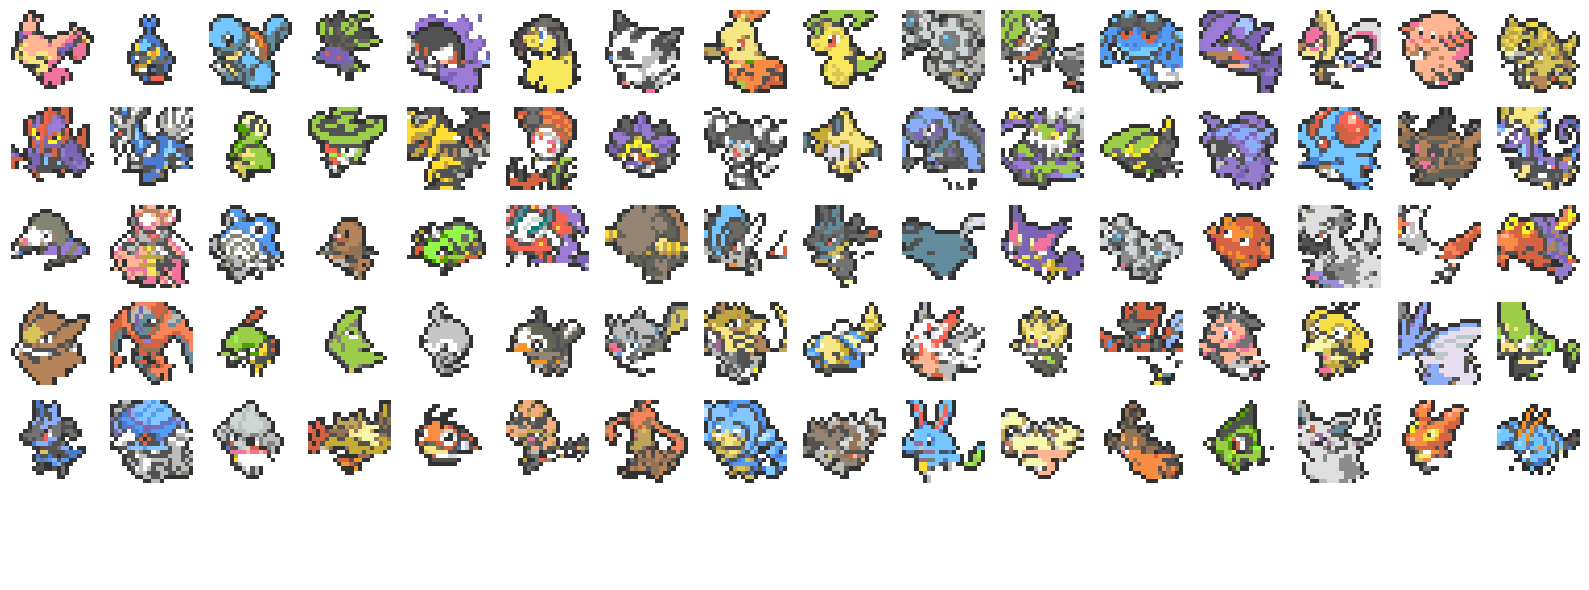

In [58]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)